In [4]:
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from neo4j import GraphDatabase
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np

sns.set(font_scale = 1.5)

### Generate Cypher Projection

@cypher:

    CALL gds.graph.create(
    'KG1',
        ["MeSH", "Document", "Protein", "Drug", "Pathway"],
        {
            MENTIONS: {orientation: 'UNDIRECTED'},
            TARGET: {orientation: 'UNDIRECTED'},
            ASSIGNS: {orientation: 'UNDIRECTED'},
            CANDIDATE: {orientation: 'UNDIRECTED'}
        }
    )

In [14]:
class FastRP():
    """Class to run Node Embedding"""
    def __init__(self) -> None:
        self.driver = GraphDatabase.driver("neo4j://localhost:7687", auth=("neo4j", "heart"))

    def close(self) -> None:
        self.driver.close()
    
    @classmethod
    def run_RP(cls, tx) -> any:
        """
        :param cls: is the class
        :param tx: is the transaction (documented in neo4j)
        :return: result.data() is the embeddings
        """
        query = ("""
        CALL gds.fastRP.stream('KG2',
            {
                embeddingDimension: 64
            }
        )
        YIELD nodeId, embedding
        RETURN gds.util.asNode(nodeId).name AS name, LABELS(gds.util.asNode(nodeId)) AS Type, gds.util.asNode(nodeId) AS NodeID, embedding AS Embedding
        """)
        result = tx.run(query)
        return result.data()

    def run_algo(self) -> any:
        """
        :param self:
        :return: result is the dataframe from the degree centrality
        """
        result = self.driver.session().write_transaction(self.run_RP)
        result = pd.DataFrame(result)
        return result

In [56]:
g = FastRP()
rp = g.run_algo()

#editing dataframe
rp["Type"] = rp["Type"].str[0]

In [57]:
rp

,name,Type,NodeID,Embedding
0,Amyloid beta A4 protein,Protein,"{'name': 'Amyloid beta A4 protein', 'id': 'P05...","[0.2588694989681244, -0.020075369626283646, 0...."
1,Matrix metalloproteinase-9,Protein,"{'name': 'Matrix metalloproteinase-9', 'id': '...","[0.07392553985118866, -0.29700663685798645, 0...."
2,Voltage-dependent P/Q-type calcium channel sub...,Protein,{'name': 'Voltage-dependent P/Q-type calcium c...,"[0.2971435487270355, 0.051755182445049286, -0...."
3,Extracellular calcium-sensing receptor,Protein,{'name': 'Extracellular calcium-sensing recept...,"[-0.04999488219618797, -0.10148849338293076, 0..."
4,"Nitric oxide synthase, brain",Protein,"{'name': 'Nitric oxide synthase, brain', 'id':...","[0.028894837945699692, -0.10687115043401718, 0..."
...,...,...,...,...
14768,Metabolism of RNA,Pathway,"{'name': 'Metabolism of RNA', 'id': 'R-HSA-895...","[-0.3695846498012543, 0.22455552220344543, 0.0..."
14769,Metabolism of proteins,Pathway,"{'name': 'Metabolism of proteins', 'id': 'R-HS...","[0.13016457855701447, -0.3284377455711365, 0.0..."
14770,Generic Transcription Pathway,Pathway,"{'name': 'Generic Transcription Pathway', 'id'...","[-0.21116232872009277, -0.09640713036060333, 0..."
14771,RNA Polymerase II Transcription,Pathway,"{'name': 'RNA Polymerase II Transcription', 'i...","[-0.21116232872009277, -0.09640713036060333, 0..."


#### Running t-SNE

In [58]:
tsne = TSNE(n_components=2, n_iter=500)
tsne_results = tsne.fit_transform(rp['Embedding'].to_list())

C:\Users\irsya\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\irsya\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [59]:
rp['tsne_x'] = [x[0] for x in list(tsne_results)]
rp['tsne_y'] = [x[1] for x in list(tsne_results)]

In [60]:
proteins = rp[rp["Type"] == "Protein"]
mesh = rp[rp["Type"] == "MeSH"]
pathway = rp[rp["Type"] == "Pathway"]
doc = rp[rp["Type"] == "Document"]
drug = rp[rp["Type"] == "Drug"]

df = pd.concat([doc, drug, pathway, proteins, mesh])

In [61]:
df

,name,Type,NodeID,Embedding,tsne_x,tsne_y
133,None,Document,"{'date': '{'Year': '2010', 'Month': 'Jul', 'Da...","[0.05641454830765724, 0.06254977732896805, 0.0...",-1.698856,5.474797
134,None,Document,"{'date': '{'Year': '2018', 'Month': '', 'Day':...","[0.3174218237400055, -0.1686793565750122, -0.0...",-7.262278,17.090891
135,None,Document,"{'date': '{'Year': '2016', 'Month': '11', 'Day...","[-0.021140309050679207, -0.3340049386024475, 0...",6.778430,-15.201788
136,None,Document,"{'date': '{'Year': '2009', 'Month': 'May', 'Da...","[0.3174218237400055, -0.1686793565750122, -0.0...",-6.956219,18.751982
137,None,Document,"{'date': '{'Year': '2014', 'Month': 'Jun', 'Da...","[0.20032918453216553, 0.01037181168794632, 0.0...",12.916620,36.248520
...,...,...,...,...,...,...
13799,cardiac papillary fibroelastoma,MeSH,"{'name': 'cardiac papillary fibroelastoma', 'i...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",19.470135,11.564103
13800,carney complex,MeSH,"{'name': 'carney complex', 'id': 'C16.131.831....","[0.17163260281085968, 0.09243705868721008, 0.1...",17.476665,11.717609
13801,pericarditis,MeSH,"{'name': 'pericarditis', 'id': 'C14.280.720'}","[0.12709170579910278, -0.05985353887081146, -0...",-14.508241,-23.494471
13802,"pericarditis, constrictive",MeSH,"{'name': 'pericarditis, constrictive', 'id': '...","[0.05308458209037781, 0.11704406887292862, 0.0...",9.524192,26.726875


<AxesSubplot:title={'center':'t-SNE from FastRP'}, xlabel='tsne_x', ylabel='tsne_y'>

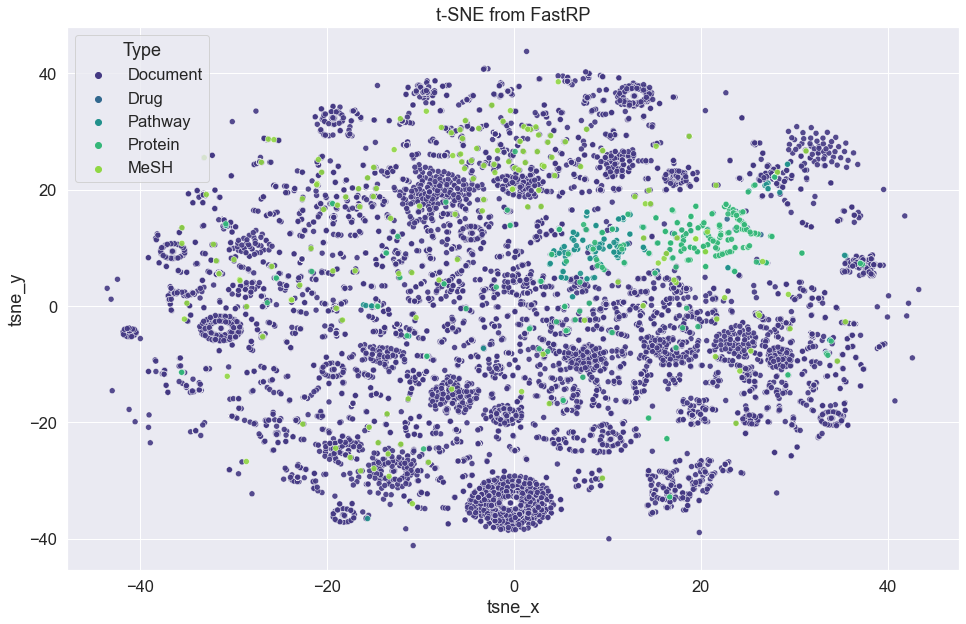

In [62]:
plt.figure(figsize=(16,10))
plt.title("t-SNE from FastRP")
sns.scatterplot(
    x="tsne_x", y="tsne_y",
    hue="Type",
    palette="viridis",
    data=df,
    legend="full",
    alpha=0.9
)

In [53]:
plt.savefig("results/tSNE.png")

<Figure size 432x288 with 0 Axes>

### t-SNE on MeSH and Proteins

In [39]:
g = FastRP()
rp = g.run_algo()

#editing dataframe
rp["Type"] = rp["Type"].str[0]

In [41]:
rp

,name,Type,NodeID,Embedding
0,Amyloid beta A4 protein,Protein,"{'name': 'Amyloid beta A4 protein', 'id': 'P05...","[0.26907479763031006, -0.029883556067943573, 0..."
1,Matrix metalloproteinase-9,Protein,"{'name': 'Matrix metalloproteinase-9', 'id': '...","[-0.011513985693454742, 0.11972668766975403, -..."
2,Voltage-dependent P/Q-type calcium channel sub...,Protein,{'name': 'Voltage-dependent P/Q-type calcium c...,"[0.14521276950836182, -0.04249870032072067, -0..."
3,Extracellular calcium-sensing receptor,Protein,{'name': 'Extracellular calcium-sensing recept...,"[-0.1765054166316986, -0.16280949115753174, 0...."
4,"Nitric oxide synthase, brain",Protein,"{'name': 'Nitric oxide synthase, brain', 'id':...","[0.2380143404006958, -0.1941092312335968, 0.17..."
...,...,...,...,...
14768,Metabolism of RNA,Pathway,"{'name': 'Metabolism of RNA', 'id': 'R-HSA-895...","[-0.2198498696088791, -0.15384843945503235, 0...."
14769,Metabolism of proteins,Pathway,"{'name': 'Metabolism of proteins', 'id': 'R-HS...","[0.21016477048397064, 0.08450081199407578, 0.2..."
14770,Generic Transcription Pathway,Pathway,"{'name': 'Generic Transcription Pathway', 'id'...","[-0.0715433657169342, 0.04498462378978729, -0...."
14771,RNA Polymerase II Transcription,Pathway,"{'name': 'RNA Polymerase II Transcription', 'i...","[-0.0715433657169342, 0.04498462378978729, -0...."


In [47]:
proteins = rp[rp["Type"] == "Protein"]
mesh = rp[rp["Type"] == "MeSH"]
pathway = rp[rp["Type"] == "Pathway"]
doc = rp[rp["Type"] == "Document"]
drug = rp[rp["Type"] == "Drug"]


df = df = pd.concat([proteins, mesh])
df = df.reset_index(drop=True)
df

,name,Type,NodeID,Embedding
0,Amyloid beta A4 protein,Protein,"{'name': 'Amyloid beta A4 protein', 'id': 'P05...","[0.26907479763031006, -0.029883556067943573, 0..."
1,Matrix metalloproteinase-9,Protein,"{'name': 'Matrix metalloproteinase-9', 'id': '...","[-0.011513985693454742, 0.11972668766975403, -..."
2,Voltage-dependent P/Q-type calcium channel sub...,Protein,{'name': 'Voltage-dependent P/Q-type calcium c...,"[0.14521276950836182, -0.04249870032072067, -0..."
3,Extracellular calcium-sensing receptor,Protein,{'name': 'Extracellular calcium-sensing recept...,"[-0.1765054166316986, -0.16280949115753174, 0...."
4,"Nitric oxide synthase, brain",Protein,"{'name': 'Nitric oxide synthase, brain', 'id':...","[0.2380143404006958, -0.1941092312335968, 0.17..."
...,...,...,...,...
595,cardiac papillary fibroelastoma,MeSH,"{'name': 'cardiac papillary fibroelastoma', 'i...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
596,carney complex,MeSH,"{'name': 'carney complex', 'id': 'C16.131.831....","[-0.02023668773472309, 0.07665052264928818, -0..."
597,pericarditis,MeSH,"{'name': 'pericarditis', 'id': 'C14.280.720'}","[-0.057666655629873276, 0.13897787034511566, -..."
598,"pericarditis, constrictive",MeSH,"{'name': 'pericarditis, constrictive', 'id': '...","[0.027660802006721497, -0.11379045248031616, -..."


In [48]:
tsne = TSNE(n_components=2, n_iter=500)
tsne_results = tsne.fit_transform(df['Embedding'].to_list())

C:\Users\irsya\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\irsya\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [50]:
df['tsne_x'] = [x[0] for x in list(tsne_results)]
df['tsne_y'] = [x[1] for x in list(tsne_results)]

In [51]:
df

,name,Type,NodeID,Embedding,tsne_x,tsne_y
0,Amyloid beta A4 protein,Protein,"{'name': 'Amyloid beta A4 protein', 'id': 'P05...","[0.26907479763031006, -0.029883556067943573, 0...",-7.609933,-7.815340
1,Matrix metalloproteinase-9,Protein,"{'name': 'Matrix metalloproteinase-9', 'id': '...","[-0.011513985693454742, 0.11972668766975403, -...",-15.638026,-2.406625
2,Voltage-dependent P/Q-type calcium channel sub...,Protein,{'name': 'Voltage-dependent P/Q-type calcium c...,"[0.14521276950836182, -0.04249870032072067, -0...",-12.753636,9.475879
3,Extracellular calcium-sensing receptor,Protein,{'name': 'Extracellular calcium-sensing recept...,"[-0.1765054166316986, -0.16280949115753174, 0....",-4.602833,-4.060700
4,"Nitric oxide synthase, brain",Protein,"{'name': 'Nitric oxide synthase, brain', 'id':...","[0.2380143404006958, -0.1941092312335968, 0.17...",-38.260555,3.034893
...,...,...,...,...,...,...
595,cardiac papillary fibroelastoma,MeSH,"{'name': 'cardiac papillary fibroelastoma', 'i...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-4.976159,2.153358
596,carney complex,MeSH,"{'name': 'carney complex', 'id': 'C16.131.831....","[-0.02023668773472309, 0.07665052264928818, -0...",1.235009,-3.359718
597,pericarditis,MeSH,"{'name': 'pericarditis', 'id': 'C14.280.720'}","[-0.057666655629873276, 0.13897787034511566, -...",-16.197067,3.667240
598,"pericarditis, constrictive",MeSH,"{'name': 'pericarditis, constrictive', 'id': '...","[0.027660802006721497, -0.11379045248031616, -...",-13.483852,9.044164


<AxesSubplot:title={'center':'t-SNE from FastRP'}, xlabel='tsne_x', ylabel='tsne_y'>

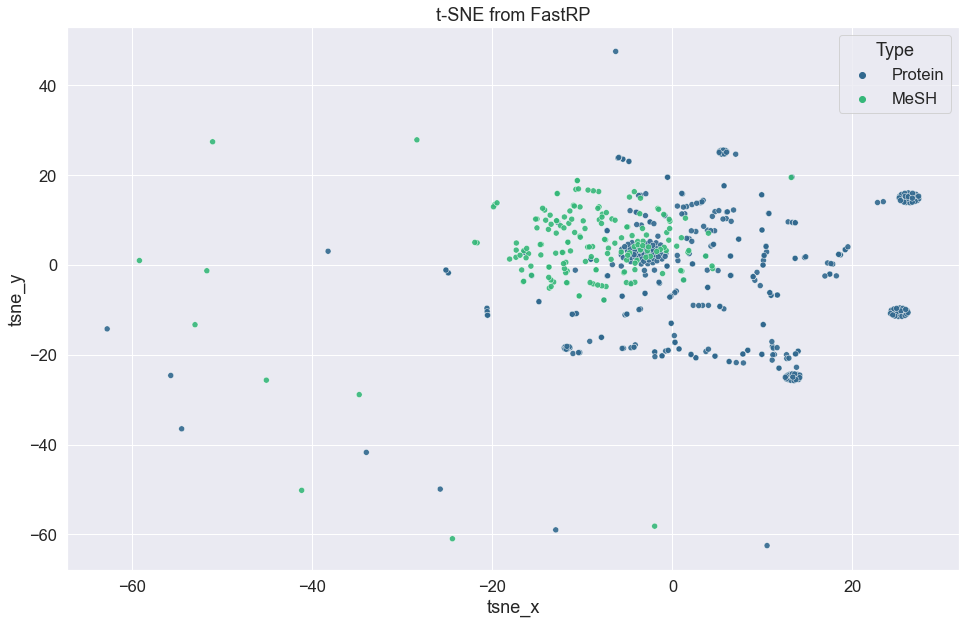

In [52]:
plt.figure(figsize=(16,10))
plt.title("t-SNE from FastRP")
sns.scatterplot(
    x="tsne_x", y="tsne_y",
    hue="Type",
    palette="viridis",
    data=df,
    legend="full",
    alpha=0.9
)